# Cell 1 - Import, percorsi, autenticazione Spotify

In [8]:
import os
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

DATA_PROCESSED_DIR = os.path.join("..", "data", "processed")
os.makedirs(DATA_PROCESSED_DIR, exist_ok=True)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✓ Imports OK")

✓ Imports OK


## Cell 2 - Song's Dataset

## Kaggle set

In [9]:
kaggle_path = "/workspaces/Music_Mood_recomender/data/data.csv"

df= pd.read_csv(kaggle_path)
print("Kaggle dataset shape:", df.shape)
df.head()


Kaggle dataset shape: (169909, 19)


,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


## Cell 3 - EXPLORATORY DATA ANALYSIS (EDA)

In [10]:
# Cell 3.1 - Dataset Overview
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"\nDataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "="*60)
print("COLUMN TYPES")
print("="*60)
print(df.dtypes)

print("\n" + "="*60)
print("MISSING VALUES")
print("="*60)
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

if missing_df['Missing Count'].sum() == 0:
    print("No missing values detected!")

print("\n" + "="*60)
print("DUPLICATES")
print("="*60)
duplicates = df.duplicated(subset=['id']).sum()
print(f"Duplicate track IDs: {duplicates}")
if duplicates > 0:
    print(f"  → {duplicates / len(df) * 100:.2f}% of dataset")

DATASET OVERVIEW

Dataset shape: 169,909 rows × 19 columns

Memory usage: 64.27 MB

COLUMN TYPES
acousticness        float64
artists              object
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
valence             float64
year                  int64
dtype: object

MISSING VALUES
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []
No missing values detected!

DUPLICATES
Duplicate track IDs: 0



FEATURE CORRELATIONS


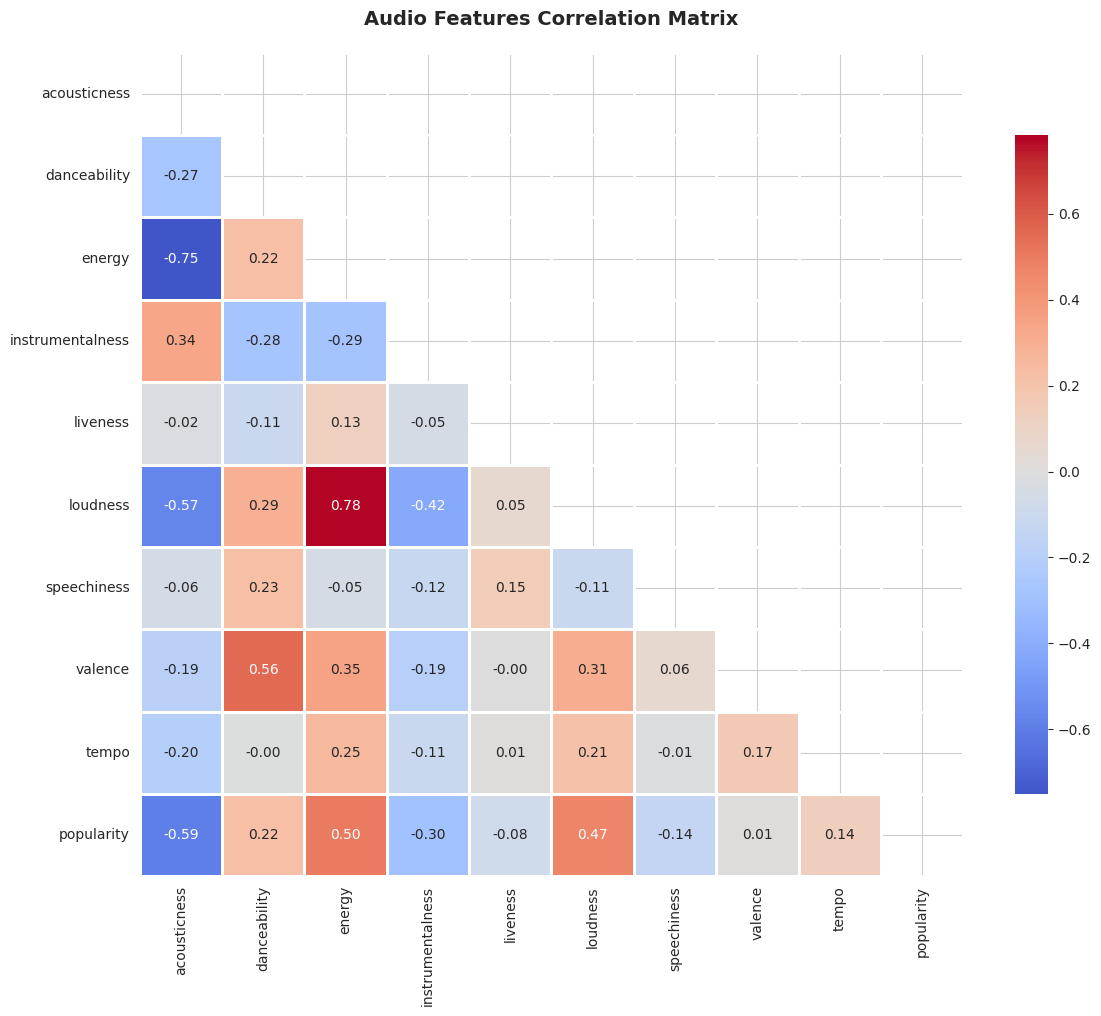


Strong Correlations (|r| > 0.5):
  - acousticness <-> energy: -0.750
  - acousticness <-> loudness: -0.567
  - acousticness <-> popularity: -0.593
  - danceability <-> valence: 0.560
  - energy <-> loudness: 0.783


In [11]:
# Cell 3.2 - Feature Correlations
print("\n" + "="*60)
print("FEATURE CORRELATIONS")
print("="*60)

# Select numerical features
numeric_features = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'valence', 'tempo', 'popularity'
]

# Correlation matrix
corr_matrix = df[numeric_features].corr()

# Heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8}
)
plt.title('Audio Features Correlation Matrix', fontweight='bold', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\nStrong Correlations (|r| > 0.5):")
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            print(f"  - {corr_matrix.columns[i]} <-> {corr_matrix.columns[j]}: {corr_val:.3f}")




TEMPORAL DISTRIBUTION

Year range: 1921 - 2020
Span: 99 years


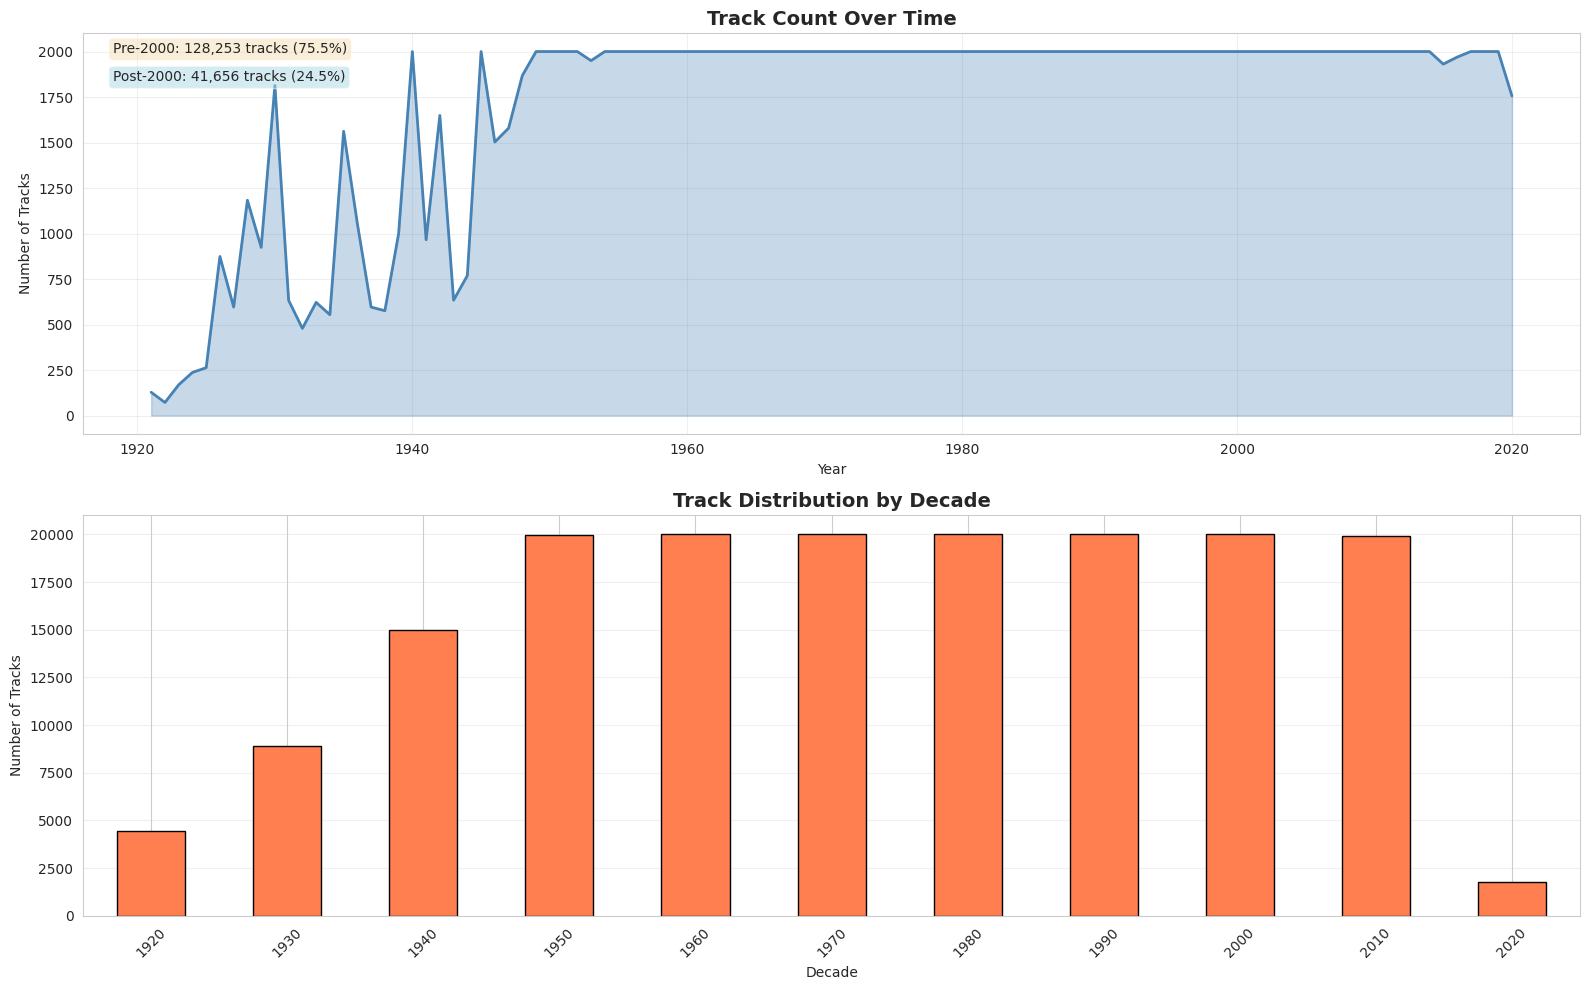


Temporal Statistics:
- Median year: 1978
- Most represented decade: 1960s (20,000 tracks)
- Oldest track: 1921
- Newest track: 2020


In [12]:
# Cell 3.3 - Temporal Analysis 
print("\n" + "="*60)
print("TEMPORAL DISTRIBUTION")
print("="*60)

# Extract year from release_date
df['year'] = df['release_date'].apply(lambda x: int(str(x)[:4]) if pd.notna(x) else np.nan)

print(f"\nYear range: {df['year'].min():.0f} - {df['year'].max():.0f}")
print(f"Span: {df['year'].max() - df['year'].min():.0f} years")

# Songs per year
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Timeline
ax1 = axes[0]
year_counts = df['year'].value_counts().sort_index()
ax1.plot(year_counts.index, year_counts.values, linewidth=2, color='steelblue')
ax1.fill_between(year_counts.index, year_counts.values, alpha=0.3, color='steelblue')
ax1.set_title('Track Count Over Time', fontweight='bold', fontsize=14)
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Tracks')
ax1.grid(True, alpha=0.3)

# Annotate key periods
pre_2000 = (df['year'] < 2000).sum()
post_2000 = (df['year'] >= 2000).sum()
ax1.text(
    0.02, 0.95,
    f'Pre-2000: {pre_2000:,} tracks ({pre_2000/len(df)*100:.1f}%)',
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
)
ax1.text(
    0.02, 0.88,
    f'Post-2000: {post_2000:,} tracks ({post_2000/len(df)*100:.1f}%)',
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5)
)

# Decade distribution
df['decade'] = (df['year'] // 10) * 10
ax2 = axes[1]
decade_counts = df['decade'].value_counts().sort_index()
decade_counts.plot(kind='bar', ax=ax2, color='coral', edgecolor='black')
ax2.set_title('Track Distribution by Decade', fontweight='bold', fontsize=14)
ax2.set_xlabel('Decade')
ax2.set_ylabel('Number of Tracks')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nTemporal Statistics:")
print(f"- Median year: {df['year'].median():.0f}")
print(f"- Most represented decade: {decade_counts.idxmax()}s ({decade_counts.max():,} tracks)")
print(f"- Oldest track: {df['year'].min():.0f}")
print(f"- Newest track: {df['year'].max():.0f}")




POPULARITY DISTRIBUTION


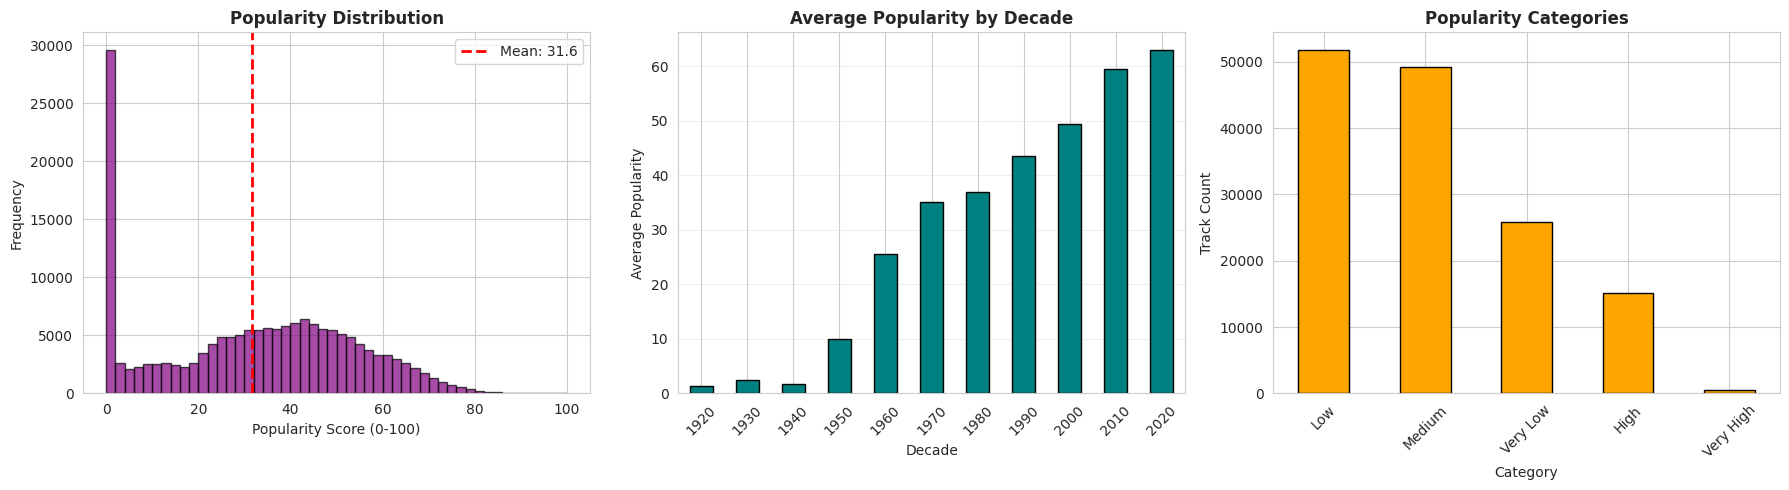


Popularity Statistics:
- Mean: 31.56
- Median: 33
- Zero popularity: 27,357 tracks (16.1%)
- High popularity (>60): 15,617 tracks (9.2%)

Popularity is right-skewed (most tracks have low popularity)


In [13]:
# Cell 3.4 - Popularity Analysis 
print("\n" + "="*60)
print("POPULARITY DISTRIBUTION")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Popularity histogram
ax1 = axes[0]
df['popularity'].hist(bins=50, ax=ax1, color='purple', alpha=0.7, edgecolor='black')
ax1.set_title('Popularity Distribution', fontweight='bold', fontsize=12)
ax1.set_xlabel('Popularity Score (0-100)')
ax1.set_ylabel('Frequency')
ax1.axvline(df['popularity'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f"Mean: {df['popularity'].mean():.1f}")
ax1.legend()

# Popularity by decade
ax2 = axes[1]
df.groupby('decade')['popularity'].mean().plot(kind='bar', ax=ax2, color='teal', edgecolor='black')
ax2.set_title('Average Popularity by Decade', fontweight='bold', fontsize=12)
ax2.set_xlabel('Decade')
ax2.set_ylabel('Average Popularity')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# Popularity categories
ax3 = axes[2]
pop_categories = pd.cut(
    df['popularity'], 
    bins=[0, 20, 40, 60, 80, 100],
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
)
pop_categories.value_counts().plot(kind='bar', ax=ax3, color='orange', edgecolor='black')
ax3.set_title('Popularity Categories', fontweight='bold', fontsize=12)
ax3.set_xlabel('Category')
ax3.set_ylabel('Track Count')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

print("\nPopularity Statistics:")
print(f"- Mean: {df['popularity'].mean():.2f}")
print(f"- Median: {df['popularity'].median():.0f}")
print(f"- Zero popularity: {(df['popularity'] == 0).sum():,} tracks ({(df['popularity'] == 0).sum()/len(df)*100:.1f}%)")
print(f"- High popularity (>60): {(df['popularity'] > 60).sum():,} tracks ({(df['popularity'] > 60).sum()/len(df)*100:.1f}%)")

print("\nPopularity is right-skewed (most tracks have low popularity)")


ARTIST ANALYSIS

Top 20 Artists by Track Count:
artists
['Эрнест Хемингуэй']              1215
['Francisco Canaro']               938
['Эрих Мария Ремарк']              781
['Ignacio Corsini']                620
['Frank Sinatra']                  592
['Bob Dylan']                      539
['The Rolling Stones']             512
['Johnny Cash']                    502
['The Beach Boys']                 491
['Elvis Presley']                  488
['Francisco Canaro', 'Charlo']     459
['Queen']                          426
['Dean Martin']                    411
['The Beatles']                    410
['Miles Davis']                    408
['Billie Holiday']                 400
['Fleetwood Mac']                  398
['Ella Fitzgerald']                354
['Lead Belly']                     339
['Led Zeppelin']                   338
Name: count, dtype: int64


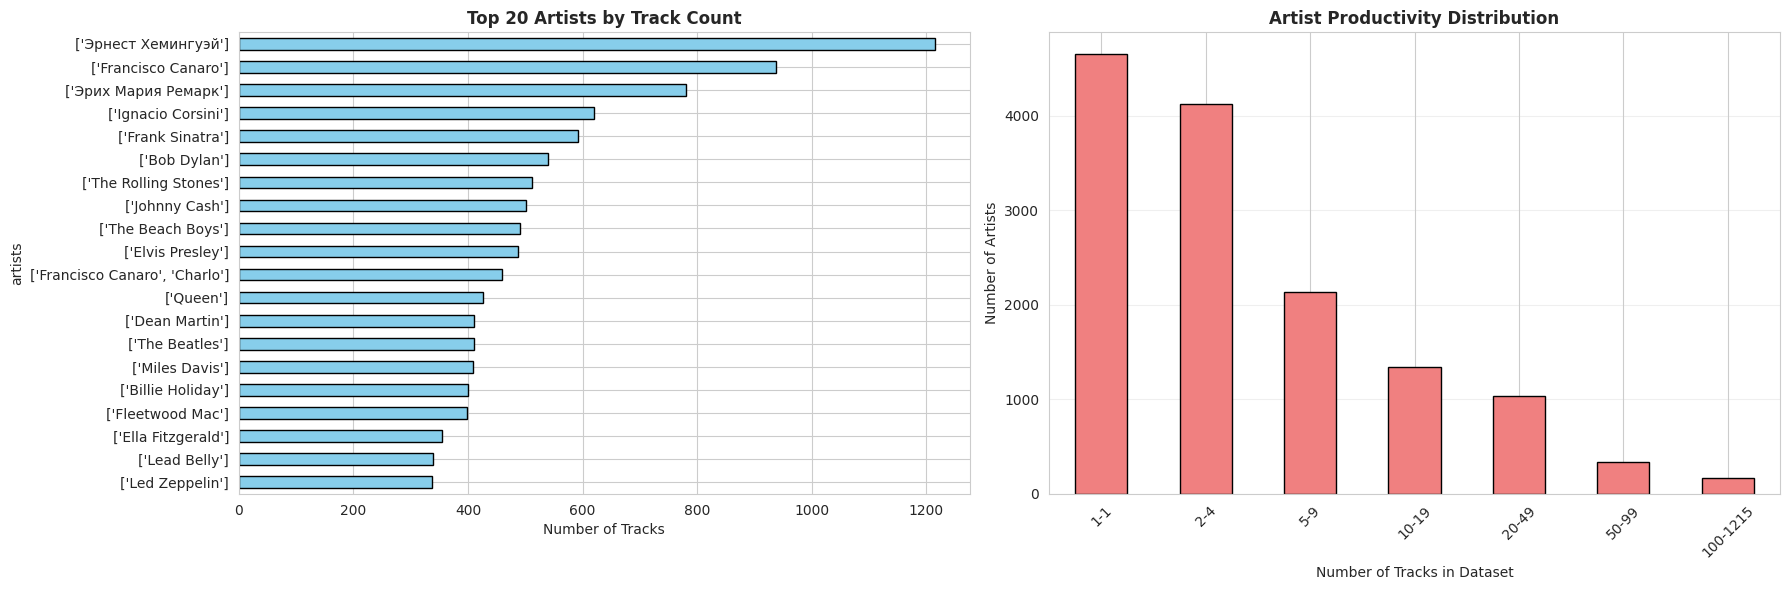


Artist Statistics:
 - Unique artists: 33,375
 - Most prolific artist: ['Эрнест Хемингуэй'] (1215 tracks)
 - Single-track artists: 19,572 (58.6%)
 - Multi-artist collaborations: 34,640 tracks

Long-tail structure: many artists appear only once, while a small number contribute a large share of the tracks.


In [14]:
# Cell 3.5 - Artist Analysis
print("\n" + "="*60)
print("ARTIST ANALYSIS")
print("="*60)

# Top artists by track count
print("\nTop 20 Artists by Track Count:")
top_artists = df['artists'].value_counts().head(20)
print(top_artists)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Top 20 artists
ax1 = axes[0]
top_artists.plot(kind='barh', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Top 20 Artists by Track Count', fontweight='bold', fontsize=12)
ax1.set_xlabel('Number of Tracks')
ax1.invert_yaxis()

# Unique artists distribution
ax2 = axes[1]
artist_track_counts = df['artists'].value_counts()
bins = [1, 2, 5, 10, 20, 50, 100, artist_track_counts.max() + 1]
artist_dist = pd.cut(artist_track_counts, bins=bins).value_counts().sort_index()
artist_dist.plot(kind='bar', ax=ax2, color='lightcoral', edgecolor='black')
ax2.set_title('Artist Productivity Distribution', fontweight='bold', fontsize=12)
ax2.set_xlabel('Number of Tracks in Dataset')
ax2.set_ylabel('Number of Artists')
ax2.set_xticklabels([f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)], rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nArtist Statistics:")
print(f" - Unique artists: {df['artists'].nunique():,}")
print(f" - Most prolific artist: {top_artists.index[0]} ({top_artists.values[0]} tracks)")
print(f" - Single-track artists: {(artist_track_counts == 1).sum():,} "
      f"({(artist_track_counts == 1).sum()/len(artist_track_counts)*100:.1f}%)")
print(f" - Multi-artist collaborations: {df['artists'].str.contains(',').sum():,} tracks")

print("\nLong-tail structure: many artists appear only once, while a small number contribute a large share of the tracks.")



TRACK DURATION ANALYSIS


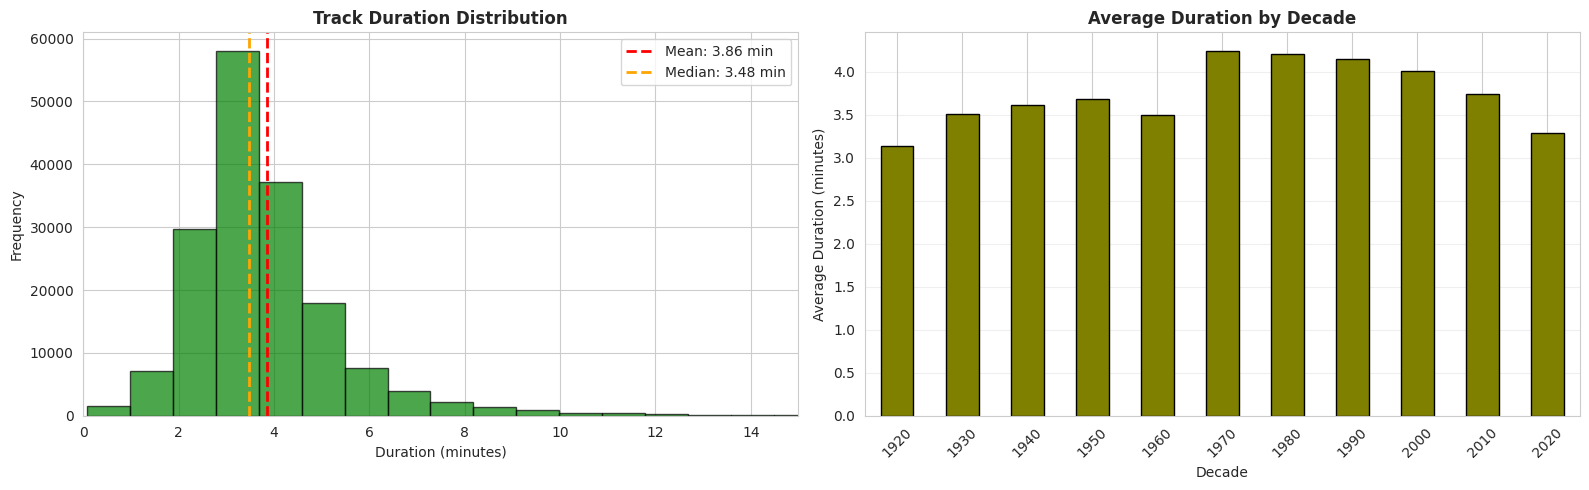


Duration Statistics:
 - Mean: 3.86 minutes
 - Median: 3.48 minutes
 - Shortest: 0.09 minutes
 - Longest: 90.06 minutes
 - Standard 3-4 min songs: 59,938 (35.3%)

 The distribution is right-skewed: there are some longer tracks, but they become increasingly rare. 
 Average duration remains relatively stable across decades, with a tendency to decrease in the most recent years (2010–2020).


In [15]:
# Cell 3.6 - Duration Analysis
print("\n" + "="*60)
print("TRACK DURATION ANALYSIS")
print("="*60)

# Convert to minutes
df['duration_min'] = df['duration_ms'] / 60000

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Duration distribution
ax1 = axes[0]
df['duration_min'].hist(bins=100, ax=ax1, color='green', alpha=0.7, edgecolor='black')
ax1.set_title('Track Duration Distribution', fontweight='bold', fontsize=12)
ax1.set_xlabel('Duration (minutes)')
ax1.set_ylabel('Frequency')
ax1.set_xlim(0, 15)  # Focus on main distribution
ax1.axvline(df['duration_min'].mean(), color='red', linestyle='--', linewidth=2,
            label=f"Mean: {df['duration_min'].mean():.2f} min")
ax1.axvline(df['duration_min'].median(), color='orange', linestyle='--', linewidth=2,
            label=f"Median: {df['duration_min'].median():.2f} min")
ax1.legend()

# Duration by decade
ax2 = axes[1]
df.groupby('decade')['duration_min'].mean().plot(kind='bar', ax=ax2, color='olive', edgecolor='black')
ax2.set_title('Average Duration by Decade', fontweight='bold', fontsize=12)
ax2.set_xlabel('Decade')
ax2.set_ylabel('Average Duration (minutes)')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nDuration Statistics:")
print(f" - Mean: {df['duration_min'].mean():.2f} minutes")
print(f" - Median: {df['duration_min'].median():.2f} minutes")
print(f" - Shortest: {df['duration_min'].min():.2f} minutes")
print(f" - Longest: {df['duration_min'].max():.2f} minutes")
print(f" - Standard 3-4 min songs: {((df['duration_min'] >= 3) & (df['duration_min'] <= 4)).sum():,} "
      f"({((df['duration_min'] >= 3) & (df['duration_min'] <= 4)).sum()/len(df)*100:.1f}%)")

print("\n The distribution is right-skewed: there are some longer tracks, but they become increasingly rare. \n"
      " Average duration remains relatively stable across decades, with a tendency to decrease in the most recent years (2010–2020).")


AUDIO FEATURES DISTRIBUTIONS

--- ACOUSTICNESS ---
   min: 0.0000
   max: 0.9960
  mean: 0.4932
median: 0.4920
   std: 0.3766
    p5: 0.0014
   p25: 0.0945
   p50: 0.4920
   p75: 0.8880
   p95: 0.9920

--- DANCEABILITY ---
   min: 0.0000
   max: 0.9880
  mean: 0.5381
median: 0.5480
   std: 0.1753
    p5: 0.2330
   p25: 0.4170
   p50: 0.5480
   p75: 0.6670
   p95: 0.8130

--- ENERGY ---
   min: 0.0000
   max: 1.0000
  mean: 0.4886
median: 0.4810
   std: 0.2674
    p5: 0.0765
   p25: 0.2630
   p50: 0.4810
   p75: 0.7100
   p95: 0.9250

--- INSTRUMENTALNESS ---
   min: 0.0000
   max: 1.0000
  mean: 0.1619
median: 0.0002
   std: 0.3093
    p5: 0.0000
   p25: 0.0000
   p50: 0.0002
   p75: 0.0868
   p95: 0.9030

--- LIVENESS ---
   min: 0.0000
   max: 1.0000
  mean: 0.2067
median: 0.1350
   std: 0.1768
    p5: 0.0595
   p25: 0.0984
   p50: 0.1350
   p75: 0.2630
   p95: 0.6170

--- SPEECHINESS ---
   min: 0.0000
   max: 0.9690
  mean: 0.0941
median: 0.0450
   std: 0.1499
    p5: 0.0281
   p2

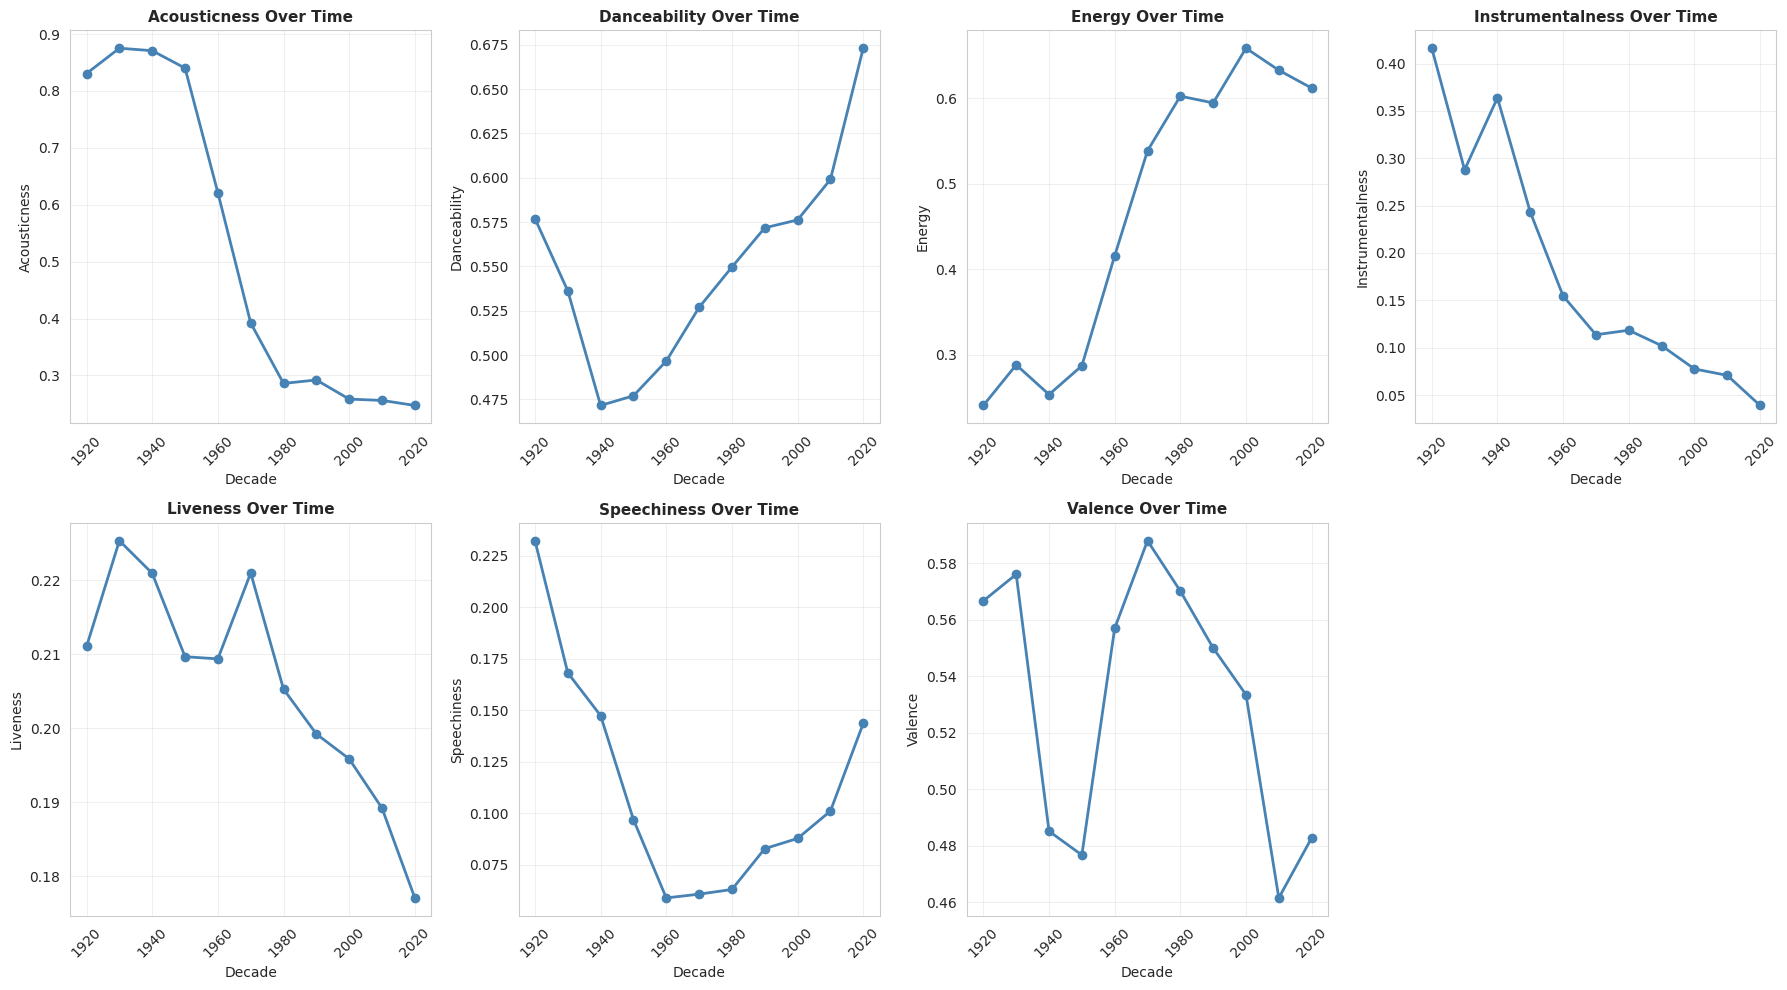


Interpretation of Audio Features Over Time

- Acousticness decreases sharply after the 1950s. In the 2000–2020 period it remains very low and stable.

- Danceability drops between 1930 and 1950, then increases steadily from the 1960s onward. 
  Contemporary music (2000–2020) is much more oriented toward rhythm and dance.

- Energy rises significantly starting from the 1960s, reaches its peak around the 2000s, 
  and then slightly declines in the 2010–2020 period.

- Instrumentalness declines sharply from the 1930s to recent decades. Modern music is almost always vocal,
  with purely instrumental tracks becoming rare.

- Liveness shows a clear downward trend. It is higher in the early decades and steadily decreases from the 1970s to 2020.

- Speechiness decreases strongly until the 1980s, then rises slightly. In recent decades it increases a bit.

- Valence (positive emotional content) varies considerably over time:
    - decreases in the 1940s–50s
    - rises in the 1960s–70s
    - de

In [16]:
# Cell 3.7 - Feature Evolution Over Time
print("\n" + "="*60)
print("AUDIO FEATURES DISTRIBUTIONS")
print("="*60)

audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
                  'liveness', 'speechiness', 'valence']

stats = {}

for feat in audio_features:
    series = df[feat].dropna()

    stats[feat] = {
        "min": series.min(),
        "max": series.max(),
        "mean": series.mean(),
        "median": series.median(),
        "std": series.std(),
        "p5": series.quantile(0.05),
        "p25": series.quantile(0.25),
        "p50": series.quantile(0.50),
        "p75": series.quantile(0.75),
        "p95": series.quantile(0.95)
    }

# Print table-like output
for feat, values in stats.items():
    print(f"\n--- {feat.upper()} ---")
    for stat_name, stat_value in values.items():
        print(f"{stat_name:>6}: {stat_value:.4f}")

print("\n" + "="*60)
print("AUDIO FEATURES EVOLUTION OVER TIME")
print("="*60)

# Group by decade
features_by_decade = df.groupby('decade')[audio_features].mean()

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for i, feat in enumerate(audio_features + ['tempo']):
    ax = axes[i]
    if feat in features_by_decade.columns:
        features_by_decade[feat].plot(kind='line', ax=ax, marker='o', linewidth=2, markersize=6, color='steelblue')
        ax.set_title(f'{feat.capitalize()} Over Time', fontweight='bold', fontsize=11)
        ax.set_xlabel('Decade')
        ax.set_ylabel(feat.capitalize())
        ax.grid(True, alpha=0.3)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Remove empty subplot
axes[-1].remove()

plt.tight_layout()
plt.show()

print("""
Interpretation of Audio Features Over Time

- Acousticness decreases sharply after the 1950s. In the 2000–2020 period it remains very low and stable.

- Danceability drops between 1930 and 1950, then increases steadily from the 1960s onward. 
  Contemporary music (2000–2020) is much more oriented toward rhythm and dance.

- Energy rises significantly starting from the 1960s, reaches its peak around the 2000s, 
  and then slightly declines in the 2010–2020 period.

- Instrumentalness declines sharply from the 1930s to recent decades. Modern music is almost always vocal,
  with purely instrumental tracks becoming rare.

- Liveness shows a clear downward trend. It is higher in the early decades and steadily decreases from the 1970s to 2020.

- Speechiness decreases strongly until the 1980s, then rises slightly. In recent decades it increases a bit.

- Valence (positive emotional content) varies considerably over time:
    - decreases in the 1940s–50s
    - rises in the 1960s–70s
    - decreases again in the 2000s
    - rises slightly in the 2020s
This reflects shifts in the emotional tone of music, alternating between more “positive” periods and more neutral or melancholic ones.
""")


## Cell 4 - Data Preprocessing

In [17]:
rename_cols = {
    "id": "track_id",
    "name": "track_name",
    "artists": "artist_name",
    "popularity": "popularity",
    "release_date": "release_date"
}

df = df.rename(columns=rename_cols)

# colonne da mantenere
keep = [
    "track_id", "track_name", "artist_name", "popularity", "release_date",
    "acousticness","danceability","energy","instrumentalness","liveness",
    "loudness","speechiness","tempo","valence","duration_ms"
]

df = df[keep].dropna(subset=["track_id"])
df["source_type"] = "kaggle"
df["source_label"] = "spotify_1921_2020"

print("Clean Kaggle shape:", df.shape)
df.head()


Clean Kaggle shape: (169909, 17)


,track_id,track_name,artist_name,popularity,release_date,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms,source_type,source_label
0,6KbQ3uYMLKb5jDxLF7wYDD,Singende Bataillone 1. Teil,['Carl Woitschach'],0,1928,0.995,0.708,0.1950,0.563,0.1510,-12.428,0.0506,118.469,0.7790,158648,kaggle,spotify_1921_2020
1,6KuQTIu1KoTTkLXKrwlLPV,"Fantasiestücke, Op. 111: Più tosto lento","['Robert Schumann', 'Vladimir Horowitz']",0,1928,0.994,0.379,0.0135,0.901,0.0763,-28.454,0.0462,83.972,0.0767,282133,kaggle,spotify_1921_2020
2,6L63VW0PibdM1HDSBoqnoM,Chapter 1.18 - Zamek kaniowski,['Seweryn Goszczyński'],0,1928,0.604,0.749,0.2200,0.000,0.1190,-19.924,0.9290,107.177,0.8800,104300,kaggle,spotify_1921_2020
3,6M94FkXd15sOAOQYRnWPN8,Bebamos Juntos - Instrumental (Remasterizado),['Francisco Canaro'],0,1928-09-25,0.995,0.781,0.1300,0.887,0.1110,-14.734,0.0926,108.003,0.7200,180760,kaggle,spotify_1921_2020
4,6N6tiFZ9vLTSOIxkj8qKrd,"Polonaise-Fantaisie in A-Flat Major, Op. 61","['Frédéric Chopin', 'Vladimir Horowitz']",1,1928,0.990,0.210,0.2040,0.908,0.0980,-16.829,0.0424,62.149,0.0693,687733,kaggle,spotify_1921_2020


In [18]:
df = df.dropna(subset=["track_id"])
df["track_id"] = df["track_id"].astype(str).str.strip()
df = df[df["track_id"] != ""]

df = df.drop_duplicates(subset="track_id").reset_index(drop=True)

print("Shape dopo deduplica:", df.shape)

Shape dopo deduplica: (169909, 17)


In [19]:
# Convertiamo release_date in anno (utile per modello)
def extract_year(x):
    try:
        return int(str(x)[:4])
    except:
        return np.nan

df["year"] = df["release_date"].apply(extract_year)

# Riordino colonne
cols_new_order = [
    "track_id", "track_name", "artist_name", "popularity", "year",
    "acousticness", "danceability", "energy", "instrumentalness", "liveness",
    "loudness", "speechiness", "tempo", "valence", "duration_ms"
]

df = df[cols_new_order]
df.head()


,track_id,track_name,artist_name,popularity,year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms
0,6KbQ3uYMLKb5jDxLF7wYDD,Singende Bataillone 1. Teil,['Carl Woitschach'],0,1928,0.995,0.708,0.1950,0.563,0.1510,-12.428,0.0506,118.469,0.7790,158648
1,6KuQTIu1KoTTkLXKrwlLPV,"Fantasiestücke, Op. 111: Più tosto lento","['Robert Schumann', 'Vladimir Horowitz']",0,1928,0.994,0.379,0.0135,0.901,0.0763,-28.454,0.0462,83.972,0.0767,282133
2,6L63VW0PibdM1HDSBoqnoM,Chapter 1.18 - Zamek kaniowski,['Seweryn Goszczyński'],0,1928,0.604,0.749,0.2200,0.000,0.1190,-19.924,0.9290,107.177,0.8800,104300
3,6M94FkXd15sOAOQYRnWPN8,Bebamos Juntos - Instrumental (Remasterizado),['Francisco Canaro'],0,1928,0.995,0.781,0.1300,0.887,0.1110,-14.734,0.0926,108.003,0.7200,180760
4,6N6tiFZ9vLTSOIxkj8qKrd,"Polonaise-Fantaisie in A-Flat Major, Op. 61","['Frédéric Chopin', 'Vladimir Horowitz']",1,1928,0.990,0.210,0.2040,0.908,0.0980,-16.829,0.0424,62.149,0.0693,687733


In [41]:
output_path = os.path.join(DATA_PROCESSED_DIR, "spotify_dataset_clean.csv")
df.to_csv(output_path, index=False)

print("🎉 Dataset pulito salvato in:")
print(output_path)

🎉 Dataset pulito salvato in:
../data/processed/spotify_dataset_clean.csv
